In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
df = pd.read_csv("iris.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
df.drop_duplicates()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [5]:
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [6]:
df.variety.value_counts()

variety
Setosa        50
Versicolor    50
Virginica     50
Name: count, dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal.length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal.width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal.length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal.width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


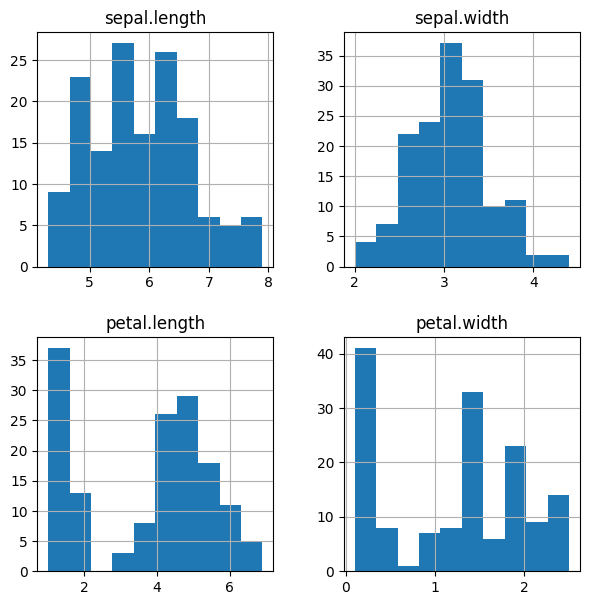

In [8]:
df.hist(figsize=(7, 7))
plt.show()

In [9]:
le = LabelEncoder()
train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train = train.iloc[:, :-1]
y_train = le.fit_transform(train.variety)
X_test = test.iloc[:, :-1]
y_test = le.fit_transform(test.variety)

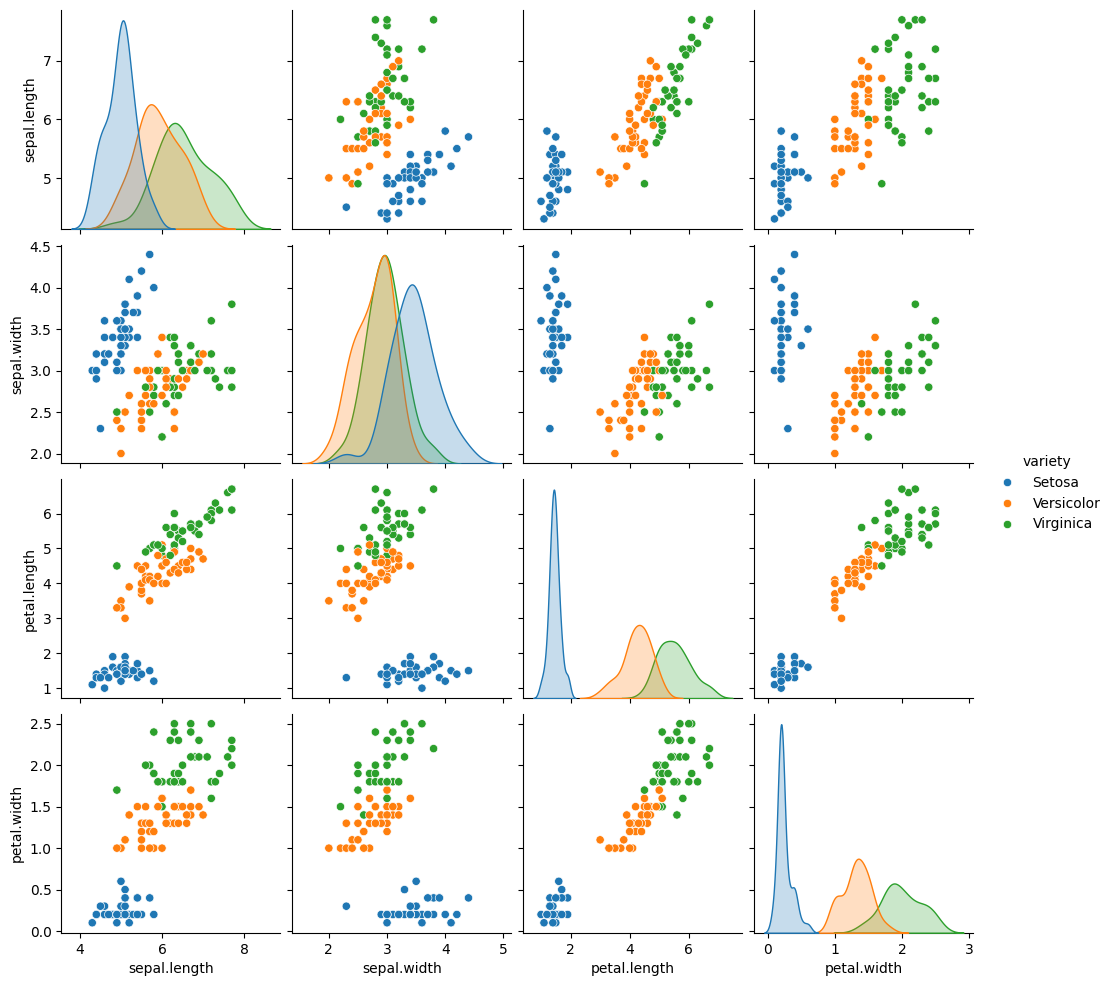

In [10]:
sn.pairplot(train, hue='variety')
plt.show()

In [11]:
def get_mean_vector(df):
    columns = df.columns
    mean_vector = []
    
    for i in range(len(columns)):
        mean_vector.append(sum(df[columns[i]]) / len(df[columns[i]]))
    
    return np.array(mean_vector)

In [12]:
def get_covariance_matrix(df):    
    columns = df.columns
    covariance_matrix = []
    mean_vector = get_mean_vector(df)

    for i in range(len(columns)):
        covariance_vector = []
        for j in range(len(columns)):
            Ex = df[columns[i]] - mean_vector[i]
            Ey = df[columns[j]] - mean_vector[j]
            covariance_vector.append(sum(Ex * Ey) / len(df[columns[i]]))
        covariance_matrix.append(covariance_vector)
    
    return np.array(covariance_matrix)

In [13]:
def get_mahalanobis_distance(X, u, covariance_matrix):
    X_u = X - u
    return np.sqrt(np.dot(np.dot(X_u, np.linalg.inv(covariance_matrix)), X_u.T))

In [14]:
def get_euclidean_distance(X, u):
    X_u = X - u
    return np.sqrt(np.dot(X_u, X_u.T))

In [15]:
def get_mean_vector_and_cov_matrices(X_train, y_train):
    mean_vectors = [None] * len(np.unique(y_train))
    cov_matrices = [None] * len(np.unique(y_train))

    for target in np.unique(y_train):
        target_data = X_train[y_train == target]
        mean_vectors[target] = get_mean_vector(target_data)
        cov_matrices[target] = get_covariance_matrix(target_data)

    return mean_vectors, cov_matrices

In [16]:
def predict_with_mahalanobis(mean_vectors, cov_matrices):
    y_pred = []

    for sample in X_test.values:
        distances = [get_mahalanobis_distance(sample, mean_vectors[i], cov_matrices[i]) for i in range(len(mean_vectors))]
        predicted_class = np.argmin(distances)
        y_pred.append(predicted_class)
    
    return y_pred

In [20]:
def predict_with_euclidean(mean_vectors):
    y_pred = []
    for sample in X_test.values:
        distances = [get_euclidean_distance(sample, mean_vectors[i]) for i in range(len(mean_vectors))]
        predicted_class = np.argmin(distances)
        y_pred.append(predicted_class)
    
    return y_pred

In [21]:
def plot_result(correct_samples, incorrect_samples, X_test):
    fig, axs = plt.subplots(2, 3, figsize=(20, 20))
    columns = X_test.columns
    k = 0
    m = 0

    for i in range(len(columns) - 1):
        for j in range(i + 1, len(columns)):
            axs[k, m].scatter(incorrect_samples.values[:, i], incorrect_samples.values[:, j], c='red', label='Incorrect Classification')
            axs[k, m].scatter(correct_samples.values[:, i], correct_samples.values[:, j], c='green', label='Correct Classification')

            axs[k, m].set(xlabel=columns[j], ylabel=columns[i], title='Correct and Incorrect Classifications')
            axs[k, m].legend()

            m += 1
            if m == 3:
                k += 1
                m = 0


In [47]:
def predict(mean_vectors, cov_matrices, X_test, y_test, method):
    if(method == "mahalanobis"):
        y_pred = predict_with_mahalanobis(mean_vectors, cov_matrices)
    else:
        y_pred = predict_with_euclidean(mean_vectors)
    
    correct_samples = X_test[y_pred == y_test]
    incorrect_samples = X_test[y_pred != y_test]
    print(test[y_pred != y_test])
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    print("Accuracy is {} for {} distance method".format(acc, method))
    plot_result(correct_samples, incorrect_samples, X_test)


In [27]:
mean_vectors, cov_matrices = get_mean_vector_and_cov_matrices(X_train, y_train)

In [30]:
mean_vectors, cov_matrices

([array([4.99  , 3.4525, 1.45  , 0.245 ]),
  array([5.9195122 , 2.77073171, 4.24146341, 1.32195122]),
  array([6.53333333, 2.96666667, 5.52051282, 2.        ])],
 [array([[0.1239    , 0.105275  , 0.0185    , 0.0092    ],
         [0.105275  , 0.15249375, 0.013375  , 0.0078875 ],
         [0.0185    , 0.013375  , 0.033     , 0.0065    ],
         [0.0092    , 0.0078875 , 0.0065    , 0.010975  ]]),
  array([[0.28693635, 0.09861987, 0.19114218, 0.05908388],
         [0.09861987, 0.10011898, 0.09389649, 0.04600833],
         [0.19114218, 0.09389649, 0.22584176, 0.07933373],
         [0.05908388, 0.04600833, 0.07933373, 0.04122546]]),
  array([[0.4165812 , 0.09854701, 0.30623932, 0.04820513],
         [0.09854701, 0.0991453 , 0.09042735, 0.05871795],
         [0.30623932, 0.09042735, 0.28573307, 0.05076923],
         [0.04820513, 0.05871795, 0.05076923, 0.08205128]])])

    sepal.length  sepal.width  petal.length  petal.width     variety
68           6.2          2.2           4.5          1.5  Versicolor
Accuracy is 96.67 for mahalanobis distance method


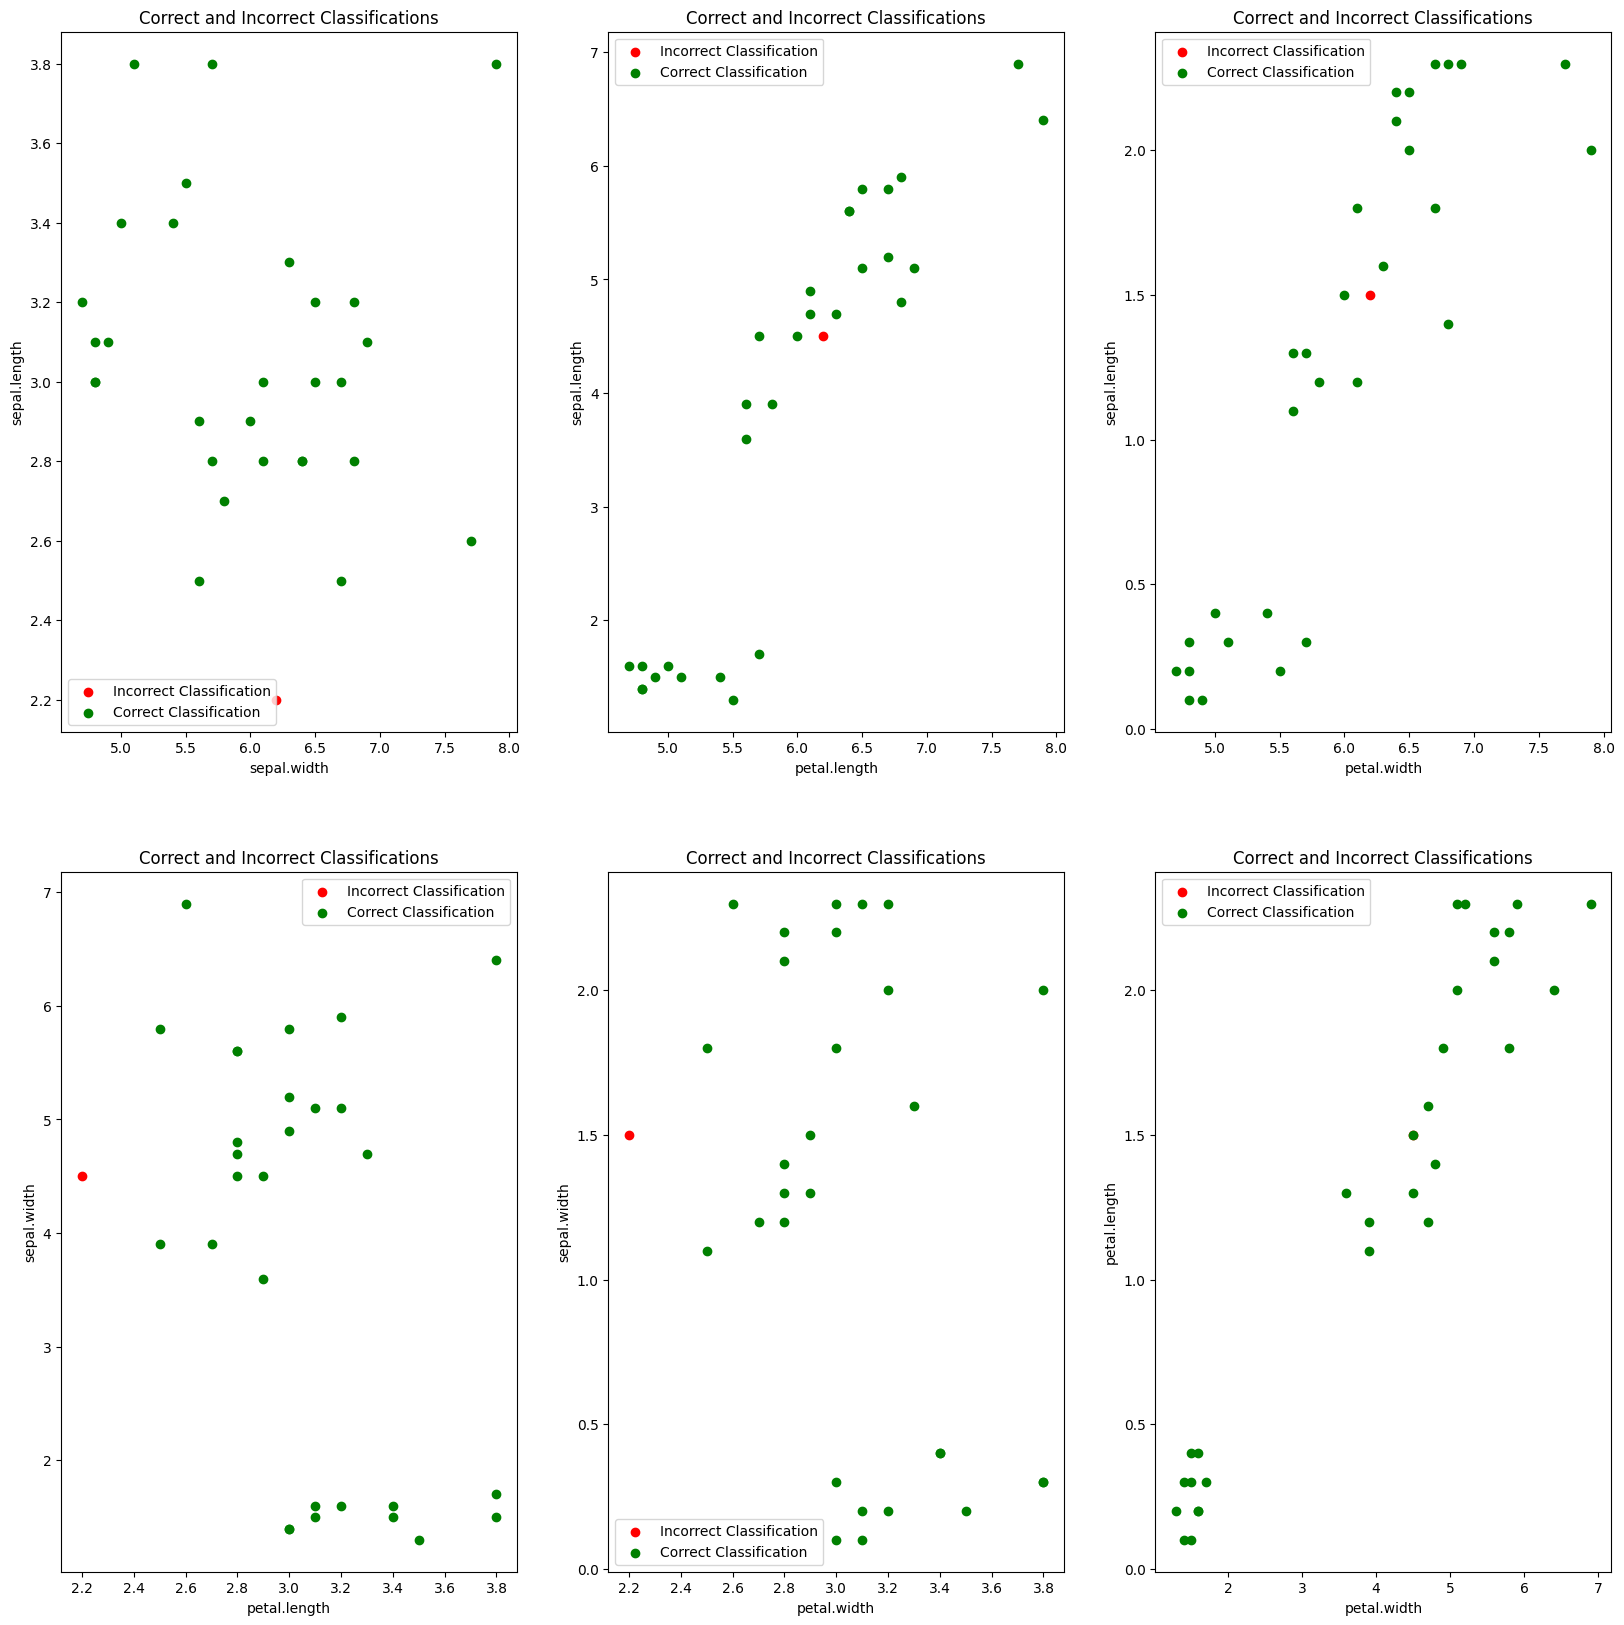

In [48]:
predict(mean_vectors, cov_matrices, X_test, y_test, method="mahalanobis")

    sepal.length  sepal.width  petal.length  petal.width     variety
76           6.8          2.8           4.8          1.4  Versicolor
Accuracy is 96.67 for euclidean distance method


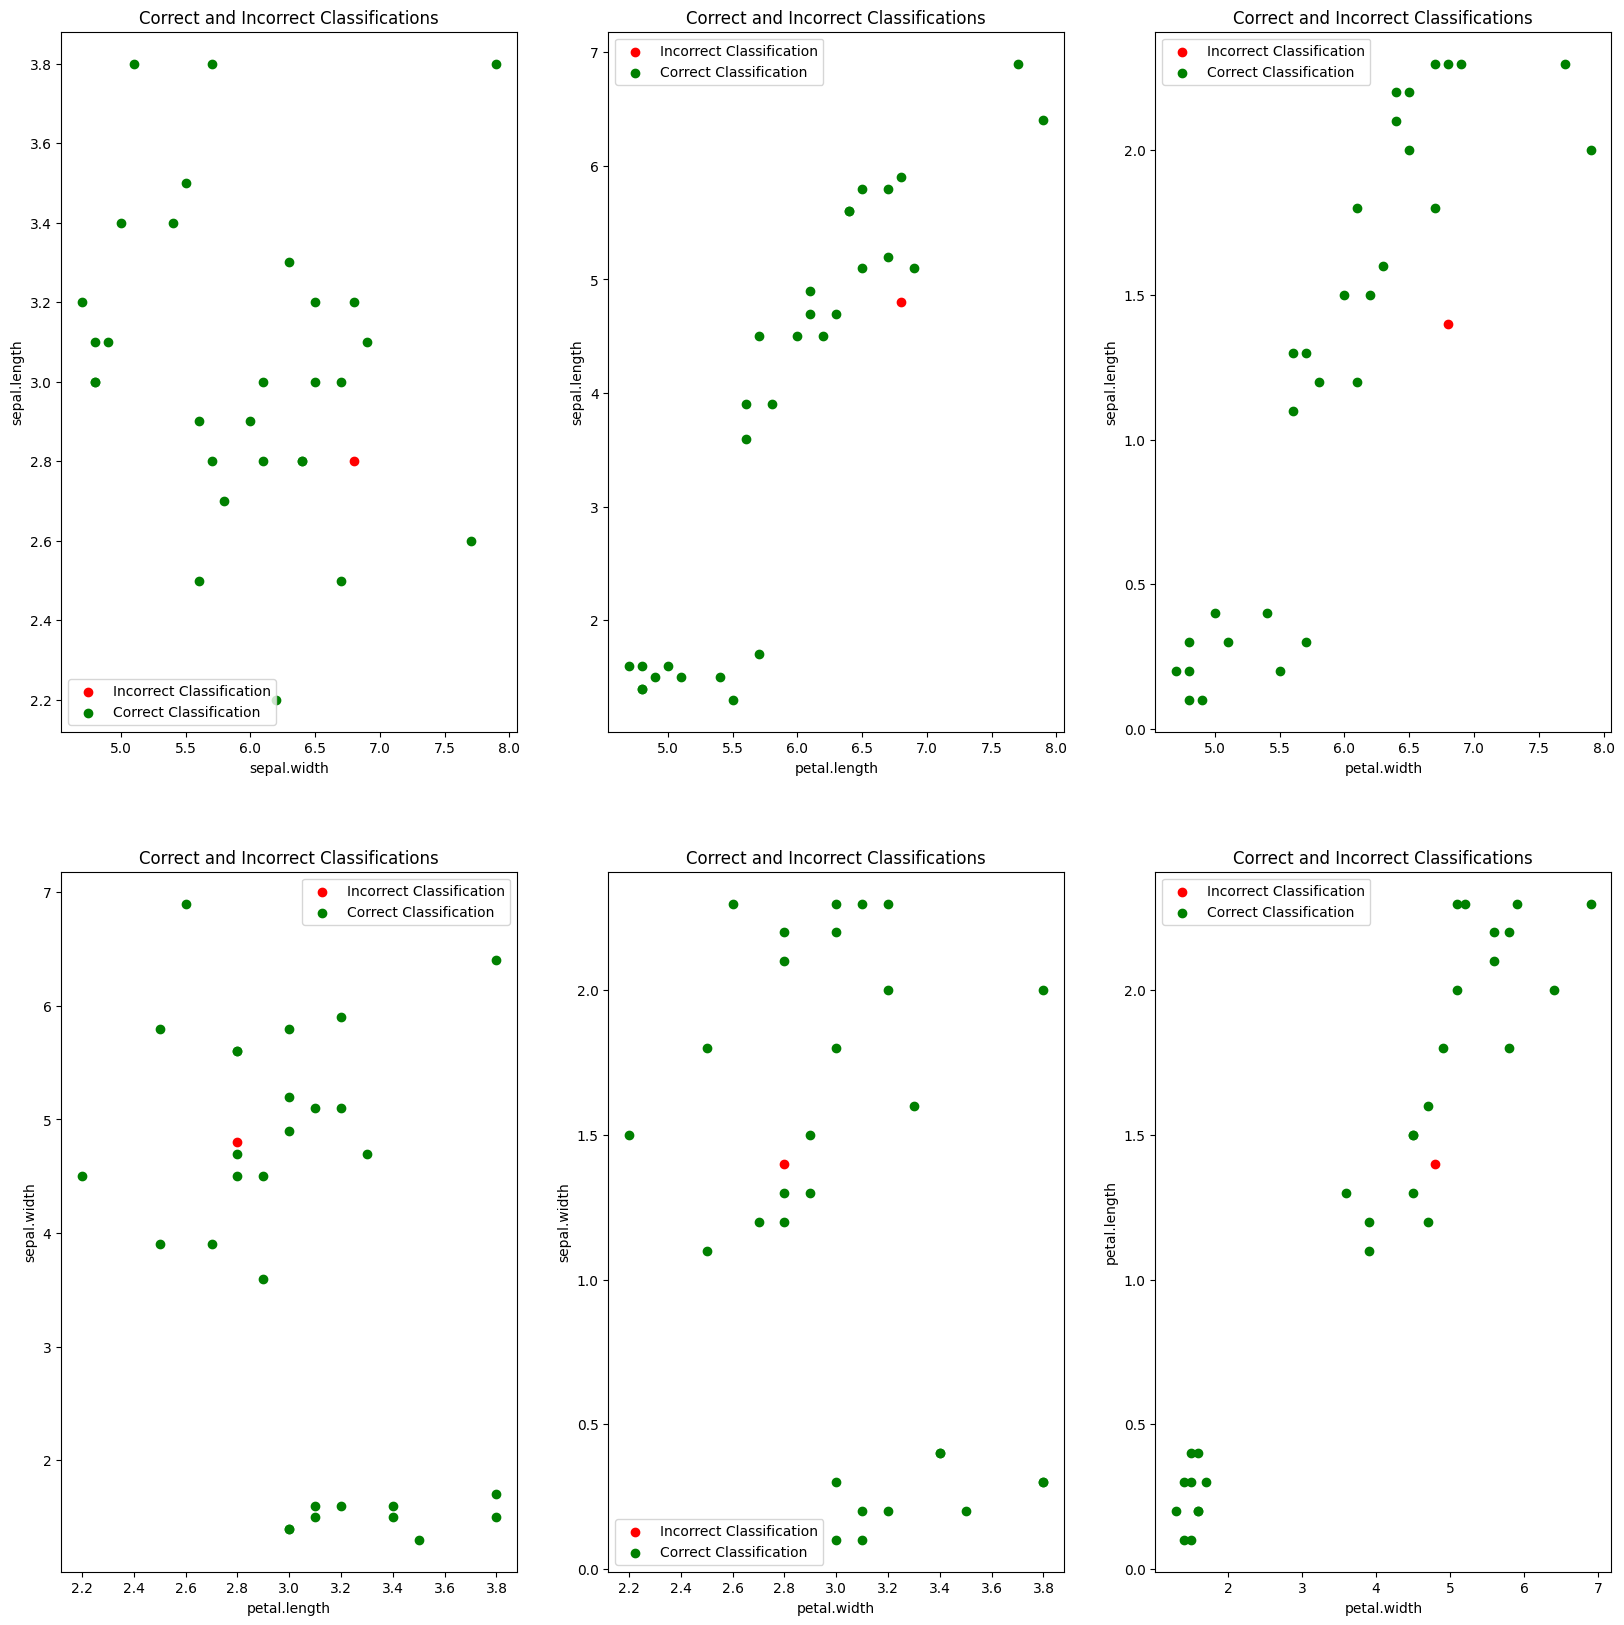

In [49]:
predict(mean_vectors, cov_matrices, X_test, y_test, method="euclidean")